In [30]:
# %load "neural_network.py"
import numpy as np
import matplotlib as mpl;
mpl.use("Agg");
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
%matplotlib inline

LEAKY_RELU_LAMBDA = 0.01;

def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y
def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.savefig("decision.eps", format = "eps");
    plt.show()
    
def tanh(z): return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z));
    
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z));
    
# def relu(z): return np.maximum(z, np.zeros(z.shape));
def relu(z): return (-LEAKY_RELU_LAMBDA * z * (z < 0.0)) + (z * (z >= 0.0))
diff_relu = np.vectorize(lambda x: -LEAKY_RELU_LAMBDA if x < 0.0 else 1.0);


########################################################################################################################
########################################################################################################################
# YOUR ASSSIGMENT STARTS HERE
# FOLLOW THE INSTRUCTION BELOW TO BUILD AND TRAIN A 3-LAYER NEURAL NETWORK
########################################################################################################################
########################################################################################################################
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))
        

    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''

        # YOU IMPLMENT YOUR actFun HERE
        if type == "tanh": return tanh(z);
        elif type == "sigmoid": return sigmoid(z);
        elif type == "relu": return relu(z);

    def diff_actFun(self, z, type):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''

        # YOU IMPLEMENT YOUR diff_actFun HERE
        if type == "tanh": return 1.0 - tanh(z) * tanh(z);
        elif type == "sigmoid": return sigmoid(z) * (1.0 - sigmoid(z)); 
        elif type == "relu": return diff_relu(z);
        return None

    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1

        :param X: input data
        :param actFun: activation function
        :return
		:
        '''
        # YOU IMPLEMENT YOUR feedforward HERE

        new_X = np.hstack([np.ones((X.shape[0], 1)), X])
        # print "new X: ", new_X.shape
        W1_bias = np.vstack([self.b1, self.W1]);
        # print "b1: ", self.b1.shape
        # print "W1 bias: ", W1_bias.shape
        self.z1 = np.dot(new_X, W1_bias);
        self.a1 = actFun(self.z1);
        # print "A1: ", self.a1.shape
        new_a1 = np.hstack([np.ones((self.a1.shape[0], 1)), self.a1]);
        # print "new a1: ", new_a1.shape
        W2_bias = np.vstack([self.b2, self.W2]);
        # print "b2: ", self.b2.shape
        # print "W2 bias: ", W2_bias.shape
        self.z2 = np.dot(new_a1, W2_bias);
        self.probs = actFun(self.z2);
        # print "probs: ", self.probs.shape

    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss


        # YOU IMPLEMENT YOUR CALCULATION OF THE LOSS HERE
        if self.actFun_type == "tanh":
            new_probs = (self.probs + 1.0) / 2.0;
        else:
            new_probs = self.probs;
            
        data_loss = -np.sum(np.multiply(self.yhot, np.log(new_probs)));
        # data_loss = np.sum(np.multiply(self.yhot, np.log(self.probs)));

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return (1. / num_examples) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''
        self.yhot = np.zeros((self.probs.shape[0], 2));
        self.yhot[np.arange(self.probs.shape[0]), y] = 1;

        # IMPLEMENT YOUR BACKPROP HERE
        e2 = -np.multiply(self.yhot - self.probs, self.diff_actFun(self.z2, self.actFun_type));
        # print "e2:", e2.shape
        e1 = np.multiply(np.dot(e2, self.W2.T), self.diff_actFun(self.z1, self.actFun_type))
        # print "e1:", e1.shape

        db2 = np.sum(e2, axis = 0);
        db1 = np.sum(e1, axis = 0);

        dW2 = np.dot(self.a1.T, e2);
        # print "dw2:", dW2.shape
        dW1 = np.dot(X.T, e1);
        # print "dw1:", dW1.shape
        
        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)
            # print "W1:", self.W1.shape
            # print "dW1:", dW1.shape
            # print "W2:", self.W2.shape
            # print "dW2:", dW2.shape

            # print "db1:", db1.shape
            # print "db2:", db2.shape
            # print "reg: ", self.reg_lambda

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plots the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)

def main():
    # # generate and visualize Make-Moons dataset
    X, y = generate_data()
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.savefig("data.eps", format = "eps");
    plt.show()

    # model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='tanh')
    # model.fit_model(X,y, num_passes = 2000)
    # model.visualize_decision_boundary(X,y)

if __name__ == "__main__":
    main()


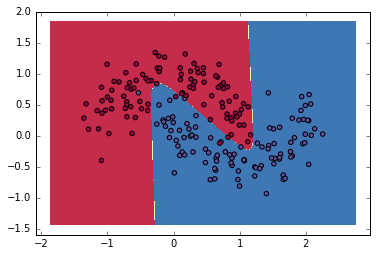

Loss after iteration 19000: 0.056586


Loss after iteration 18000: 0.056614


Loss after iteration 17000: 0.056649


Loss after iteration 16000: 0.056691


Loss after iteration 15000: 0.056744


Loss after iteration 14000: 0.056809


Loss after iteration 13000: 0.056890


Loss after iteration 12000: 0.056992


Loss after iteration 11000: 0.057122


Loss after iteration 10000: 0.057289


Loss after iteration 9000: 0.057507


Loss after iteration 8000: 0.057798


Loss after iteration 7000: 0.058197


Loss after iteration 6000: 0.058761


Loss after iteration 5000: 0.059600


Loss after iteration 4000: 0.060957


Loss after iteration 3000: 0.065005


Loss after iteration 2000: 0.113288


Loss after iteration 1000: 0.114729


Loss after iteration 0: 0.115364


In [33]:
X, y = generate_data()
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='sigmoid')
model.fit_model(X,y);
model.visualize_decision_boundary(X,y)

In [20]:
print model.nn_input_dim
print model.nn_hidden_dim
print model.nn_output_dim

2
3
2


In [95]:
np.zeros((3, 2)) + 1.0

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

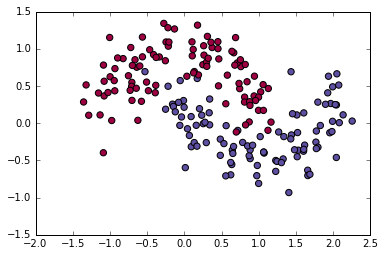

In [6]:
X, y = generate_data()
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
# plt.show()
plt.savefig('data.png')

In [31]:
foo = np.array([3.0, 2.0, 1.0, 0.0, -1.0, -100.0])
(-LEAKY_RELU_LAMBDA * foo * (foo < 0.0)) + (foo * (foo >= 0.0))
print relu(foo)
print diff_relu(foo)

[ 3.    2.    1.    0.    0.01  1.  ]
[ 1.    1.    1.    1.   -0.01 -0.01]
